In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py
import copy
import scipy
from scipy import stats
import time

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
trainfilename = '/home/greatofdream/killxbq/ftraining-0.h5'
# fr = h5py.File(trainfilename, 'r')
data = np.load('/opt/dadQiang/train_full.npy')
label = np.load('/opt/dadQiang/label_full.npy')


In [43]:
label.dtype

torch.float32

In [3]:
data1 = np.mean(data[:,:150],axis=1).reshape((len(data),1))-data

In [5]:
with h5py.File('./train_data_1.h5','w') as opt:
    opt.create_dataset('data',data=data1,dtype='float32',compression='gzip')
    opt.create_dataset('label',data=label,dtype='int',compression='gzip')


In [6]:
x = torch.from_numpy(data1[:].reshape(-1,1,1029)).float()
y = torch.from_numpy(label[:]).float()

In [7]:
print(x.shape,y.shape,len(train_dataset),len(valid_dataset))

torch.Size([1420827, 1, 1029]) torch.Size([1420827, 1029]) 1200000 220827


In [7]:
train_dataset = TensorDataset(x[:1200000], y[:1200000])
valid_dataset = TensorDataset(x[1200000:], y[1200000:])

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

该事例的击中时间为: [295 299 307 314 336]
该事例每个时间的击中电荷数为: [1. 1. 1. 1. 1.]


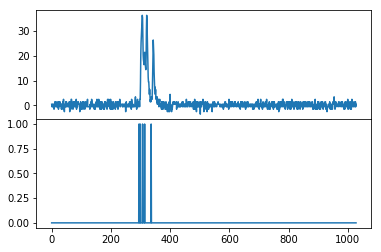

In [37]:
idx = 1604
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0})
ax1.plot(x[idx][0].numpy())
idx_n = np.where(y[idx].numpy()>0)[0]
ax2.plot(y[idx].numpy())
print('该事例的击中时间为:', idx_n)
print('该事例每个时间的击中电荷数为:', y[idx][idx_n].numpy())

In [38]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=4, kernel_size=7, stride=1, padding=3), # batch, 4, 1029
            nn.LeakyReLU(0.1),
            nn.Conv1d(in_channels=4, out_channels=8, kernel_size=7, stride=1, padding=3), # batch, 8, 1029
            nn.LeakyReLU(0.1),
            nn.ConvTranspose1d(in_channels=8, out_channels=4, kernel_size=7, stride=1, padding=3), # batch, 8, 1029
            nn.LeakyReLU(0.1),
            nn.ConvTranspose1d(in_channels=4, out_channels=1, kernel_size=7, stride=1, padding=3), # batch, 4, 1029
            nn.LeakyReLU(0.1)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [39]:
model = MLP()
model.eval()
# model._initialize_weights()
model.eval()

MLP(
  (conv): Sequential(
    (0): Conv1d(1, 4, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv1d(4, 8, kernel_size=(7,), stride=(1,), padding=(3,))
    (3): LeakyReLU(negative_slope=0.1)
    (4): ConvTranspose1d(8, 4, kernel_size=(7,), stride=(1,), padding=(3,))
    (5): LeakyReLU(negative_slope=0.1)
    (6): ConvTranspose1d(4, 1, kernel_size=(7,), stride=(1,), padding=(3,))
    (7): LeakyReLU(negative_slope=0.1)
  )
)

In [14]:
sum(param.numel() for param in model.parameters())

521

In [40]:
from torchviz import make_dot, make_dot_from_trace
make_dot(model(x),params=dict(model.named_parameters()))

RuntimeError: [enforce fail at CPUAllocator.cpp:56] posix_memalign(&data, gAlignment, nbytes) == 0. 12 vs 0


In [23]:
label

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [40]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
def my_loss(x,y):
    dis = torch.pow((x-y), 2)
    #print(torch.sum(y,dim=1).float())
    #print(torch.sum(dis,dim=1).float())
    avg_dis = torch.sum(dis,dim=1).float()/torch.sum(y, dim=1).float()
#     argx = torch.argsort(torch.round(x))
#     argy = torch.argsort(y)
#     argdis = torch.abs(argx-argy)
#     avg_argdis = torch.sum(argdis,dim=1).float()/torch.sum(y, dim=1).float()
    #print(avg_dis)
    sum_dis = avg_dis
    return torch.mean(sum_dis)

In [ ]:
model = model.train()
best_loss = 1000.

runningLoss_history=np.zeros(50)
validLoss_history=np.zeros(50)
for epoch in range(50):
    runnanNum=0
    validnanNum=0
    running_loss = 0.0
    running_acc = 0.0
    for i, (data, label) in enumerate(train_loader):
        data = data.float()
        # label = label
        
        out = model(data)
        loss = my_loss(out, label)
        if np.isnan(loss.data.item()):
            runnanNum+=1
            print('error train',out)
        else:
            running_loss += loss.data.item()*label.size(0)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0
    for (data, label) in valid_loader:
        data = data.float()
        #label = label
        out = model(data)
        #print(data.shape,out.shape,label.shape)
        #torch.Size([64, 1, 1029]) torch.Size([64, 1029]) torch.Size([64, 1029])
        loss = my_loss(out, label)
        if np.isnan(loss.data.item()):
            validnanNum+=1
            print('error',sum(label))
        else:
            valid_loss += loss.data.item() * label.size(0)
    runningLoss_history[epoch]=running_loss/(len(train_dataset)-runnanNum)
    validLoss_history[epoch]=valid_loss/(len(valid_dataset)-validnanNum)
    print(runnanNum,validnanNum)
    print('Finish {} epoch, Train Loss: {:.6f}, Valid Loss: {:.6f}'.format(epoch+1, running_loss/(len(train_dataset)), valid_loss/(len(valid_dataset))))
    cur_loss = valid_loss / (len(valid_dataset))
    if cur_loss < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = cur_loss

torch.save(best_model.state_dict(), 'model_conv1d_test_1.pt')
model.load_state_dict(best_model.state_dict())

In [44]:
torch.save(model,'xuyu.pth')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [20]:
from torchviz import make_dot, make_dot_from_trace
make_dot(model(x[0:1,:,:]),params=dict(model.named_parameters()))

OSError: [Errno 12] Cannot allocate memory

In [23]:
ipt=h5py.File('/home/greatofdream/killxbq/training.h5')
wave=ipt['Waveform']


In [24]:
wave

<HDF5 dataset "Waveform": shape (745362,), type "|V2068">

In [25]:
ipt.keys()

<KeysViewHDF5 ['GroundTruth', 'TriggerInfo', 'Waveform']>

In [26]:
len(ipt['GroundTruth'])

9839161